In [20]:
#General libraries
import os
import pandas as pd
import numpy as np

#Graph tools
import matplotlib.pyplot as plt 
import seaborn as sns

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV

from lightgbm import LGBMClassifier

from boruta import BorutaPy

#Optimization
import optuna

#Experiment tracking
import mlflow
import mlflow.lightgbm

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_path = os.path.join('data', 'train.csv')
train_extra_path = os.path.join('data', 'train_extra.csv')
test_path = os.path.join('data', 'test.csv')
sample_submission_path = os.path.join('data', 'sample_submission.csv')

raw_train_data = pd.read_csv(train_path, index_col= 'id')
train_extra = pd.read_csv(train_extra_path)
train_extra['rainfall'] = train_extra['rainfall'].map({'yes': 1, 'no': 0})
ord_cols = raw_train_data.columns
train_extra.columns = train_extra.columns.str.strip()
train_extra = train_extra[ord_cols]

raw_train_data = pd.concat([raw_train_data, train_extra], ignore_index=True)
raw_train_data.dropna(inplace= True)

raw_test_data = pd.read_csv(test_path, index_col = 'id')
sample_submission = pd.read_csv(sample_submission_path)

raw_train_data.drop_duplicates(inplace= True)

In [3]:
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2555 entries, 0 to 2555
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2555 non-null   int64  
 1   pressure       2555 non-null   float64
 2   maxtemp        2555 non-null   float64
 3   temparature    2555 non-null   float64
 4   mintemp        2555 non-null   float64
 5   dewpoint       2555 non-null   float64
 6   humidity       2555 non-null   float64
 7   cloud          2555 non-null   float64
 8   sunshine       2555 non-null   float64
 9   winddirection  2555 non-null   float64
 10  windspeed      2555 non-null   float64
 11  rainfall       2555 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 259.5 KB


In [4]:
print(raw_train_data.shape)
raw_train_data.head()

(2555, 12)


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


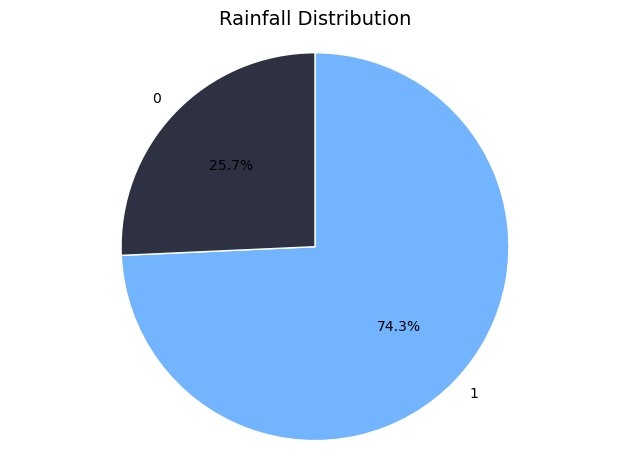

In [5]:
colors = ['#73B4FF', '#2D3142']
value_counts = raw_train_data['rainfall'].value_counts(normalize= True)
labels = value_counts.index.astype(str)
sizes = value_counts.values
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    colors= colors
)
ax.axis('equal')

# Agregar título
ax.set_title('Rainfall Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [6]:
raw_train_data.skew()

day              0.211569
pressure         0.295777
maxtemp         -0.498073
temparature     -0.572202
mintemp         -0.665021
dewpoint        -1.017435
humidity        -0.745531
cloud           -1.314520
sunshine         0.600403
winddirection    0.721490
windspeed        0.769942
rainfall        -1.111978
dtype: float64

In [17]:
boruta_mask = [False,  True, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True]

def data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])
    df['cloud'] = np.log1p(df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    
    #df_imputed = imputer.fit_transform(df)
    #df = pd.DataFrame(df_imputed, columns= df.columns)

    for col in df.columns:
        df[col +'_cat'] = df[col].astype(str)
        df[col +'_cat'] = df[col + '_cat'].astype('category')

    df = df.loc[:,boruta_mask]

    return df

def test_data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])
    df['cloud'] = np.log1p(df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    
    #df_imputed = imputer.transform(df)
    #df = pd.DataFrame(df_imputed, columns= df.columns)
    
    for col in df.columns:
        df[col +'_cat'] = df[col].astype(str)
        df[col +'_cat'] = df[col + '_cat'].astype('category')
        
    df = df.loc[:,boruta_mask]
    
    return df

In [18]:
X_train = raw_train_data.drop(columns= 'rainfall')
y_train = raw_train_data['rainfall']
X_train = data_preproccesing(X_train) 

In [19]:
X_train

,pressure,dewpoint,humidity,cloud,avg_temp,dewpoint_depression,sunshine_ratio,cloud_cat,sunshine_ratio_cat
0,1017.4,19.4,87.0,4.488636,20.55,1.2,0.012360,4.48863636973214,0.012359550561797755
1,1019.5,15.4,95.0,4.521789,16.00,1.5,0.000000,4.5217885770490405,0.0
2,1024.1,9.3,75.0,3.871201,17.00,6.8,0.172917,3.871201010907891,0.1729166666666667
3,1013.4,16.8,95.0,4.564348,17.50,1.0,0.000000,4.564348191467836,0.0
4,1021.8,9.6,52.0,3.828641,18.25,8.8,0.078261,3.828641396489095,0.0782608695652174
...,...,...,...,...,...,...,...,...,...
2551,1022.7,15.0,84.0,4.510860,17.85,2.7,0.000000,4.51085950651685,0.0
2552,1026.6,12.8,75.0,4.454347,17.45,4.5,0.011628,4.454347296253507,0.011627906976744186
2553,1025.9,13.3,75.0,4.369448,17.65,4.4,0.058228,4.3694478524670215,0.05822784810126582
2554,1025.3,13.3,78.0,4.465908,17.20,4.0,0.013793,4.465908118654584,0.013793103448275862


In [21]:
def objective(trial, X, y):
    # Definición de hiperparámetros para LightGBM
    params = {
        'objective': 'binary',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log= True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log= True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log= True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log= True),
        'n_estimators': trial.suggest_int('n_estimators', 25, 125),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0001, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'max_bin': trial.suggest_int('max_bin', 100, 300),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'random_state': 42,
        'verbosity': -1
    }
    # Creación del clasificador LightGBM con los parámetros sugeridos
    clf = LGBMClassifier(**params)
    
    # Utilizamos StratifiedKFold para mantener el balance de clases (5 particiones)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_scores = []
    val_scores = []
    
    with mlflow.start_run():
        experiment_name = "LightGBM_current_champion_calibrated"
        mlflow.set_experiment(experiment_name)
        for fold, (train_idx, val_idx) in enumerate(skf.split(X,y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            #boruta_selector = BorutaPy(clf, n_estimators= 'auto', random_state= 42)
            #boruta_selector.fit(X_train, y_train)

            X_train_selected = X_train
            X_val_selected = X_val

            #if X_train_selected.shape[1] == 0:
                #print(f"Fold {fold} skipped due to no features selected by Boruta.")
                #continue

            clf.fit(X_train_selected, y_train)

            calibrated_clf = CalibratedClassifierCV(clf, method= 'isotonic', cv = 'prefit')
            calibrated_clf.fit(X_val, y_val)
            
            train_proba = calibrated_clf.predict_proba(X_train_selected)[:, 1]
            val_proba = calibrated_clf.predict_proba(X_val_selected)[:, 1]

            train_auc = roc_auc_score(y_train, train_proba)
            val_auc = roc_auc_score(y_val, val_proba)

            train_scores.append(train_auc)
            val_scores.append(val_auc)

            mlflow.log_metric(f"train_auc_fold_{fold}", train_auc)
            mlflow.log_metric(f"val_auc_fold_{fold}", val_auc)

        avg_train_auc = np.mean(train_scores)
        avg_val_auc = np.mean(val_scores)

        mlflow.log_params(params)
        mlflow.log_metric("avg_train_auc", avg_train_auc)
        mlflow.log_metric("avg_val_auc", avg_val_auc)

        print(f"Trial {trial.number} - Avg Train AUC: {avg_train_auc:.4f} | Avg Validation AUC: {avg_val_auc:.4f}")

    return avg_val_auc


In [22]:
study = optuna.create_study(direction='maximize', sampler= optuna.samplers.TPESampler(seed= 42))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

[I 2025-03-19 12:37:46,657] A new study created in memory with name: no-name-0a48fb0a-4329-4b1d-807c-ce34638e189f
2025/03/19 12:37:46 INFO mlflow.tracking.fluent: Experiment with name 'LightGBM_current_champion_calibrated' does not exist. Creating a new experiment.
[I 2025-03-19 12:37:47,400] Trial 0 finished with value: 0.8986148886394612 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.029106359131330698, 'num_leaves': 188, 'max_depth': 3, 'min_child_samples': 19, 'min_child_weight': 0.0017073967431528124, 'subsample': 0.9197056874649611, 'colsample_bytree': 0.7606690070459253, 'reg_alpha': 0.02358594058414266, 'reg_lambda': 1.5320059381854043e-08, 'n_estimators': 122, 'min_split_gain': 0.8324593965363417, 'subsample_freq': 2, 'max_bin': 136, 'scale_pos_weight': 0.7751067647801507}. Best is trial 0 with value: 0.8986148886394612.


Trial 0 - Avg Train AUC: 0.9075 | Avg Validation AUC: 0.8986


[I 2025-03-19 12:37:48,528] Trial 1 finished with value: 0.9003658194079055 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.007309539835912915, 'num_leaves': 101, 'max_depth': 6, 'min_child_samples': 18, 'min_child_weight': 0.01474275315991467, 'subsample': 0.6198171059762151, 'colsample_bytree': 0.6736419905302216, 'reg_alpha': 0.11656915613247415, 'reg_lambda': 6.267062696005991e-07, 'n_estimators': 76, 'min_split_gain': 0.5924553274051563, 'subsample_freq': 0, 'max_bin': 222, 'scale_pos_weight': 0.7557861855309373}. Best is trial 1 with value: 0.9003658194079055.


Trial 1 - Avg Train AUC: 0.9311 | Avg Validation AUC: 0.9004


[I 2025-03-19 12:37:49,442] Trial 2 finished with value: 0.8992426277443732 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.08536189862866832, 'num_leaves': 247, 'max_depth': 4, 'min_child_samples': 14, 'min_child_weight': 0.5456725485601478, 'subsample': 0.6640914962437608, 'colsample_bytree': 0.47322294090686734, 'reg_alpha': 0.00028614897264046574, 'reg_lambda': 2.039373116525212e-08, 'n_estimators': 116, 'min_split_gain': 0.2588541036018569, 'subsample_freq': 7, 'max_bin': 162, 'scale_pos_weight': 1.2801020317667162}. Best is trial 1 with value: 0.9003658194079055.


Trial 2 - Avg Train AUC: 0.9322 | Avg Validation AUC: 0.8992


[I 2025-03-19 12:37:49,970] Trial 3 finished with value: 0.8974854496106527 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08692991511139551, 'num_leaves': 237, 'max_depth': 8, 'min_child_samples': 90, 'min_child_weight': 0.24637685958997463, 'subsample': 0.9531245410138701, 'colsample_bytree': 0.4530955012311517, 'reg_alpha': 5.805581976088804e-07, 'reg_lambda': 2.5529693461039728e-08, 'n_estimators': 57, 'min_split_gain': 0.38873842196051306, 'subsample_freq': 2, 'max_bin': 266, 'scale_pos_weight': 1.0351299900403839}. Best is trial 1 with value: 0.9003658194079055.


Trial 3 - Avg Train AUC: 0.9437 | Avg Validation AUC: 0.8975


[I 2025-03-19 12:37:50,436] Trial 4 finished with value: 0.8985701310600736 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.00191358804876923, 'num_leaves': 245, 'max_depth': 3, 'min_child_samples': 99, 'min_child_weight': 1.227380098785297, 'subsample': 0.5192294089205035, 'colsample_bytree': 0.4033132702741615, 'reg_alpha': 0.21834982897607286, 'reg_lambda': 0.022999378190815965, 'n_estimators': 98, 'min_split_gain': 0.7712932196512772, 'subsample_freq': 0, 'max_bin': 172, 'scale_pos_weight': 0.6738035892876946}. Best is trial 1 with value: 0.9003658194079055.


Trial 4 - Avg Train AUC: 0.8961 | Avg Validation AUC: 0.8986


[I 2025-03-19 12:37:51,113] Trial 5 finished with value: 0.9000051590233615 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.004589824181495649, 'num_leaves': 37, 'max_depth': 4, 'min_child_samples': 36, 'min_child_weight': 0.828752236376816, 'subsample': 0.7825344828131279, 'colsample_bytree': 0.932327645545796, 'reg_alpha': 0.0001778010520878397, 'reg_lambda': 1.1921975182604517e-07, 'n_estimators': 97, 'min_split_gain': 0.7608089701120357, 'subsample_freq': 6, 'max_bin': 254, 'scale_pos_weight': 1.2406933945465861}. Best is trial 1 with value: 0.9003658194079055.


Trial 5 - Avg Train AUC: 0.9086 | Avg Validation AUC: 0.9000


[I 2025-03-19 12:37:51,563] Trial 6 finished with value: 0.88233831481048 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0011241862095793063, 'num_leaves': 50, 'max_depth': 3, 'min_child_samples': 66, 'min_child_weight': 0.018089390092767135, 'subsample': 0.7051424146988217, 'colsample_bytree': 0.9445398843556558, 'reg_alpha': 1.7523871598466864e-06, 'reg_lambda': 4.9368087974032924e-05, 'n_estimators': 101, 'min_split_gain': 0.22887528567507331, 'subsample_freq': 0, 'max_bin': 158, 'scale_pos_weight': 0.7418319308810066}. Best is trial 1 with value: 0.9003658194079055.


Trial 6 - Avg Train AUC: 0.8904 | Avg Validation AUC: 0.8823


[I 2025-03-19 12:37:51,972] Trial 7 finished with value: 0.8945189883701286 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.018484491720988625, 'num_leaves': 264, 'max_depth': 7, 'min_child_samples': 22, 'min_child_weight': 3.7173717478250525, 'subsample': 0.7236053451493905, 'colsample_bytree': 0.8844640930984375, 'reg_alpha': 1.16097187606918, 'reg_lambda': 7.278322158604965e-06, 'n_estimators': 36, 'min_split_gain': 0.2280123690256875, 'subsample_freq': 4, 'max_bin': 264, 'scale_pos_weight': 1.7910958748845152}. Best is trial 1 with value: 0.9003658194079055.


Trial 7 - Avg Train AUC: 0.9145 | Avg Validation AUC: 0.8945


[I 2025-03-19 12:37:52,623] Trial 8 finished with value: 0.8989062155727143 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.006836314065022723, 'num_leaves': 82, 'max_depth': 3, 'min_child_samples': 37, 'min_child_weight': 5.910698619088547, 'subsample': 0.5939217592124532, 'colsample_bytree': 0.7112743730460197, 'reg_alpha': 0.02124078827890453, 'reg_lambda': 1.873554890711046e-05, 'n_estimators': 123, 'min_split_gain': 0.962451050212617, 'subsample_freq': 2, 'max_bin': 199, 'scale_pos_weight': 0.9513174647251545}. Best is trial 1 with value: 0.9003658194079055.


Trial 8 - Avg Train AUC: 0.8990 | Avg Validation AUC: 0.8989


[I 2025-03-19 12:37:52,835] Trial 9 finished with value: 0.888255481390044 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01656260589333596, 'num_leaves': 161, 'max_depth': 3, 'min_child_samples': 31, 'min_child_weight': 4.295992790539128, 'subsample': 0.5437371344001835, 'colsample_bytree': 0.48693692325473387, 'reg_alpha': 0.0002541410632209718, 'reg_lambda': 7.427695424061668, 'n_estimators': 49, 'min_split_gain': 0.672168333851138, 'subsample_freq': 8, 'max_bin': 147, 'scale_pos_weight': 1.5923245229177894}. Best is trial 1 with value: 0.9003658194079055.


Trial 9 - Avg Train AUC: 0.8899 | Avg Validation AUC: 0.8883


[I 2025-03-19 12:37:53,127] Trial 10 finished with value: 0.8883940405185069 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.004293425913714872, 'num_leaves': 106, 'max_depth': 6, 'min_child_samples': 59, 'min_child_weight': 0.029176088443780286, 'subsample': 0.40935687979507357, 'colsample_bytree': 0.5952159987827709, 'reg_alpha': 4.711326456292981, 'reg_lambda': 0.003987243249154848, 'n_estimators': 72, 'min_split_gain': 0.03116495390269103, 'subsample_freq': 10, 'max_bin': 225, 'scale_pos_weight': 0.5498101105410744}. Best is trial 1 with value: 0.9003658194079055.


Trial 10 - Avg Train AUC: 0.8828 | Avg Validation AUC: 0.8884


[I 2025-03-19 12:37:53,893] Trial 11 finished with value: 0.8999241835580513 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.005302269217536123, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 43, 'min_child_weight': 0.058229125195980946, 'subsample': 0.8137219606723853, 'colsample_bytree': 0.8459570872939662, 'reg_alpha': 1.5155324681197761e-05, 'reg_lambda': 7.335474914070231e-07, 'n_estimators': 84, 'min_split_gain': 0.6142499858782905, 'subsample_freq': 5, 'max_bin': 296, 'scale_pos_weight': 1.394515591376252}. Best is trial 1 with value: 0.9003658194079055.


Trial 11 - Avg Train AUC: 0.9136 | Avg Validation AUC: 0.8999


[I 2025-03-19 12:37:54,900] Trial 12 finished with value: 0.899694372035549 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.00272048456272903, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 8, 'min_child_weight': 0.004346338963924686, 'subsample': 0.8379008977190208, 'colsample_bytree': 0.6225421080932219, 'reg_alpha': 0.005773164097514489, 'reg_lambda': 7.831858876558289e-07, 'n_estimators': 77, 'min_split_gain': 0.5259886815314158, 'subsample_freq': 7, 'max_bin': 228, 'scale_pos_weight': 1.0637977321930083}. Best is trial 1 with value: 0.9003658194079055.


Trial 12 - Avg Train AUC: 0.9243 | Avg Validation AUC: 0.8997


[I 2025-03-19 12:37:55,757] Trial 13 finished with value: 0.8985792202248621 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01004936170208558, 'num_leaves': 61, 'max_depth': 6, 'min_child_samples': 48, 'min_child_weight': 0.15388822215316458, 'subsample': 0.8004886297648932, 'colsample_bytree': 0.9921497176719257, 'reg_alpha': 1.9797823251430704e-05, 'reg_lambda': 3.4469492705541615e-07, 'n_estimators': 94, 'min_split_gain': 0.9795940373465413, 'subsample_freq': 4, 'max_bin': 106, 'scale_pos_weight': 1.9202073896203453}. Best is trial 1 with value: 0.9003658194079055.


Trial 13 - Avg Train AUC: 0.9145 | Avg Validation AUC: 0.8986


[I 2025-03-19 12:37:56,393] Trial 14 finished with value: 0.9006368134929212 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0025488827377413204, 'num_leaves': 131, 'max_depth': 5, 'min_child_samples': 30, 'min_child_weight': 0.010671715371605732, 'subsample': 0.6290427304629029, 'colsample_bytree': 0.7857494861975948, 'reg_alpha': 4.580944721882914e-08, 'reg_lambda': 0.0003639035663823061, 'n_estimators': 65, 'min_split_gain': 0.758468881114253, 'subsample_freq': 6, 'max_bin': 236, 'scale_pos_weight': 1.541882156838812}. Best is trial 14 with value: 0.9006368134929212.


Trial 14 - Avg Train AUC: 0.9089 | Avg Validation AUC: 0.9006


[I 2025-03-19 12:37:57,192] Trial 15 finished with value: 0.9010052239769435 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.002083709692877247, 'num_leaves': 124, 'max_depth': 7, 'min_child_samples': 26, 'min_child_weight': 0.008193412907174022, 'subsample': 0.6029101705859039, 'colsample_bytree': 0.7875622099961541, 'reg_alpha': 3.522021212645743e-08, 'reg_lambda': 0.0014176549828626265, 'n_estimators': 63, 'min_split_gain': 0.4463773762491914, 'subsample_freq': 9, 'max_bin': 201, 'scale_pos_weight': 1.5707788621894663}. Best is trial 15 with value: 0.9010052239769435.


Trial 15 - Avg Train AUC: 0.9174 | Avg Validation AUC: 0.9010


[I 2025-03-19 12:37:57,530] Trial 16 finished with value: 0.8997821298819147 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0010136394391393835, 'num_leaves': 143, 'max_depth': 8, 'min_child_samples': 68, 'min_child_weight': 0.0052748115882251066, 'subsample': 0.44763877205221214, 'colsample_bytree': 0.7943449398325464, 'reg_alpha': 1.3257107451465142e-08, 'reg_lambda': 0.002270825096628849, 'n_estimators': 59, 'min_split_gain': 0.3858781177711435, 'subsample_freq': 10, 'max_bin': 198, 'scale_pos_weight': 1.594910110468211}. Best is trial 15 with value: 0.9010052239769435.


Trial 16 - Avg Train AUC: 0.8961 | Avg Validation AUC: 0.8998


[I 2025-03-19 12:37:57,863] Trial 17 finished with value: 0.9017677734056713 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.002226539128318874, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 27, 'min_child_weight': 0.0017209491444104478, 'subsample': 0.5135643731151102, 'colsample_bytree': 0.7827448588980902, 'reg_alpha': 2.3190025414817693e-08, 'reg_lambda': 0.2043268844893898, 'n_estimators': 29, 'min_split_gain': 0.42345574178518997, 'subsample_freq': 9, 'max_bin': 297, 'scale_pos_weight': 1.618083977328077}. Best is trial 17 with value: 0.9017677734056713.


Trial 17 - Avg Train AUC: 0.9091 | Avg Validation AUC: 0.9018


[I 2025-03-19 12:37:58,456] Trial 18 finished with value: 0.895315865541974 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0015842334977956756, 'num_leaves': 196, 'max_depth': 7, 'min_child_samples': 6, 'min_child_weight': 0.001370504834443831, 'subsample': 0.4994295085699882, 'colsample_bytree': 0.8654654466970888, 'reg_alpha': 1.1443807208640944e-07, 'reg_lambda': 0.5461602600174749, 'n_estimators': 32, 'min_split_gain': 0.4123115367366909, 'subsample_freq': 9, 'max_bin': 299, 'scale_pos_weight': 1.777720563263053}. Best is trial 17 with value: 0.9017677734056713.


Trial 18 - Avg Train AUC: 0.9203 | Avg Validation AUC: 0.8953


[I 2025-03-19 12:37:58,711] Trial 19 finished with value: 0.8976979536698501 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.003132428535699323, 'num_leaves': 196, 'max_depth': 7, 'min_child_samples': 51, 'min_child_weight': 0.0010050387687087524, 'subsample': 0.5554254178934618, 'colsample_bytree': 0.5695082785173808, 'reg_alpha': 4.271632513096329e-07, 'reg_lambda': 0.08558472496879414, 'n_estimators': 25, 'min_split_gain': 0.022102136529417005, 'subsample_freq': 9, 'max_bin': 126, 'scale_pos_weight': 1.986466495680231}. Best is trial 17 with value: 0.9017677734056713.


Trial 19 - Avg Train AUC: 0.8994 | Avg Validation AUC: 0.8977


[I 2025-03-19 12:37:59,085] Trial 20 finished with value: 0.8979228947980372 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0016281836199240087, 'num_leaves': 283, 'max_depth': 8, 'min_child_samples': 27, 'min_child_weight': 0.004002128881677965, 'subsample': 0.471645973649337, 'colsample_bytree': 0.732371578080673, 'reg_alpha': 5.177142553099429e-06, 'reg_lambda': 0.7165086635702093, 'n_estimators': 45, 'min_split_gain': 0.45612408711099367, 'subsample_freq': 8, 'max_bin': 183, 'scale_pos_weight': 1.4224892224192038}. Best is trial 17 with value: 0.9017677734056713.


Trial 20 - Avg Train AUC: 0.9017 | Avg Validation AUC: 0.8979


[I 2025-03-19 12:37:59,863] Trial 21 finished with value: 0.902492050815545 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.002724675611038016, 'num_leaves': 140, 'max_depth': 7, 'min_child_samples': 31, 'min_child_weight': 0.008873233963796212, 'subsample': 0.6292822770487113, 'colsample_bytree': 0.8057725585522857, 'reg_alpha': 1.2454748477359806e-08, 'reg_lambda': 0.00033150558887813414, 'n_estimators': 64, 'min_split_gain': 0.3157890379706402, 'subsample_freq': 8, 'max_bin': 251, 'scale_pos_weight': 1.5934025611544866}. Best is trial 21 with value: 0.902492050815545.


Trial 21 - Avg Train AUC: 0.9172 | Avg Validation AUC: 0.9025


[I 2025-03-19 12:38:00,379] Trial 22 finished with value: 0.9006955025234081 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.003463386423686126, 'num_leaves': 150, 'max_depth': 7, 'min_child_samples': 38, 'min_child_weight': 0.05764564565410933, 'subsample': 0.5834050978337247, 'colsample_bytree': 0.8205807288479684, 'reg_alpha': 1.2055361274327509e-08, 'reg_lambda': 0.00041703321692402337, 'n_estimators': 46, 'min_split_gain': 0.15748564161600231, 'subsample_freq': 9, 'max_bin': 282, 'scale_pos_weight': 1.739173622055312}. Best is trial 21 with value: 0.902492050815545.


Trial 22 - Avg Train AUC: 0.9131 | Avg Validation AUC: 0.9007


[I 2025-03-19 12:38:01,238] Trial 23 finished with value: 0.9016297094599303 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.001992467632567055, 'num_leaves': 164, 'max_depth': 7, 'min_child_samples': 26, 'min_child_weight': 0.0029620815967504478, 'subsample': 0.6491913648753161, 'colsample_bytree': 0.6729962322979055, 'reg_alpha': 8.709638316834726e-08, 'reg_lambda': 0.005284378972306484, 'n_estimators': 62, 'min_split_gain': 0.32703187925349236, 'subsample_freq': 8, 'max_bin': 251, 'scale_pos_weight': 1.6685483790099775}. Best is trial 21 with value: 0.902492050815545.


Trial 23 - Avg Train AUC: 0.9199 | Avg Validation AUC: 0.9016


[I 2025-03-19 12:38:02,048] Trial 24 finished with value: 0.9011706386167418 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0013464316089907002, 'num_leaves': 166, 'max_depth': 8, 'min_child_samples': 15, 'min_child_weight': 0.002022495613394498, 'subsample': 0.6651868570322841, 'colsample_bytree': 0.6817268876084766, 'reg_alpha': 2.5110711998705306e-07, 'reg_lambda': 0.029556302848730315, 'n_estimators': 39, 'min_split_gain': 0.2834515458950055, 'subsample_freq': 8, 'max_bin': 252, 'scale_pos_weight': 1.732978749253444}. Best is trial 21 with value: 0.902492050815545.


Trial 24 - Avg Train AUC: 0.9321 | Avg Validation AUC: 0.9012


[I 2025-03-19 12:38:02,554] Trial 25 finished with value: 0.900408903035192 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.002364801808430206, 'num_leaves': 210, 'max_depth': 6, 'min_child_samples': 44, 'min_child_weight': 0.0030085426425863144, 'subsample': 0.7400623474371264, 'colsample_bytree': 0.7206902390584, 'reg_alpha': 9.50789246109797e-08, 'reg_lambda': 0.36991256854281973, 'n_estimators': 53, 'min_split_gain': 0.11710637087060821, 'subsample_freq': 7, 'max_bin': 280, 'scale_pos_weight': 1.4439455219046433}. Best is trial 21 with value: 0.902492050815545.


Trial 25 - Avg Train AUC: 0.9103 | Avg Validation AUC: 0.9004


[I 2025-03-19 12:38:02,900] Trial 26 finished with value: 0.8879788138248849 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.010135061167470314, 'num_leaves': 172, 'max_depth': 7, 'min_child_samples': 61, 'min_child_weight': 0.03258199398528747, 'subsample': 0.6681990101766859, 'colsample_bytree': 0.6524122591883045, 'reg_alpha': 1.6544335516764596e-06, 'reg_lambda': 7.491520684074881, 'n_estimators': 67, 'min_split_gain': 0.3535421529564534, 'subsample_freq': 10, 'max_bin': 242, 'scale_pos_weight': 1.2701566272862033}. Best is trial 21 with value: 0.902492050815545.


Trial 26 - Avg Train AUC: 0.8858 | Avg Validation AUC: 0.8880


[I 2025-03-19 12:38:04,110] Trial 27 finished with value: 0.9004455582816572 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.003269417195898762, 'num_leaves': 228, 'max_depth': 8, 'min_child_samples': 33, 'min_child_weight': 0.007795779161880583, 'subsample': 0.8686116797369191, 'colsample_bytree': 0.5611669365075695, 'reg_alpha': 1.1037498438012655e-08, 'reg_lambda': 7.650165585995413e-05, 'n_estimators': 87, 'min_split_gain': 0.31800799040281413, 'subsample_freq': 6, 'max_bin': 277, 'scale_pos_weight': 1.8675340005843042}. Best is trial 21 with value: 0.902492050815545.


Trial 27 - Avg Train AUC: 0.9248 | Avg Validation AUC: 0.9004


[I 2025-03-19 12:38:04,575] Trial 28 finished with value: 0.8932740270510788 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.04612912035679684, 'num_leaves': 214, 'max_depth': 6, 'min_child_samples': 11, 'min_child_weight': 0.00231547271259362, 'subsample': 0.7574475852581055, 'colsample_bytree': 0.8955523290193588, 'reg_alpha': 3.054478776318524e-05, 'reg_lambda': 0.010998053302823814, 'n_estimators': 25, 'min_split_gain': 0.5470382987149671, 'subsample_freq': 8, 'max_bin': 211, 'scale_pos_weight': 1.6888347940477937}. Best is trial 21 with value: 0.902492050815545.


Trial 28 - Avg Train AUC: 0.9344 | Avg Validation AUC: 0.8933


[I 2025-03-19 12:38:05,213] Trial 29 finished with value: 0.9007511724330317 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.007346193597046038, 'num_leaves': 126, 'max_depth': 7, 'min_child_samples': 19, 'min_child_weight': 0.0019873481331964685, 'subsample': 0.5578805373419577, 'colsample_bytree': 0.749737210028517, 'reg_alpha': 0.0017934555574602793, 'reg_lambda': 0.06258310586085777, 'n_estimators': 41, 'min_split_gain': 0.11392762382704044, 'subsample_freq': 7, 'max_bin': 251, 'scale_pos_weight': 1.485220112081907}. Best is trial 21 with value: 0.902492050815545.


Trial 29 - Avg Train AUC: 0.9240 | Avg Validation AUC: 0.9008


[I 2025-03-19 12:38:06,055] Trial 30 finished with value: 0.9006640780961778 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.001434459356311345, 'num_leaves': 179, 'max_depth': 7, 'min_child_samples': 23, 'min_child_weight': 0.0010909941960562553, 'subsample': 0.40700406299187253, 'colsample_bytree': 0.8228633801536336, 'reg_alpha': 1.6702113849191823e-06, 'reg_lambda': 0.004489171815567844, 'n_estimators': 84, 'min_split_gain': 0.481308220146592, 'subsample_freq': 5, 'max_bin': 292, 'scale_pos_weight': 1.6729169945144207}. Best is trial 21 with value: 0.902492050815545.


Trial 30 - Avg Train AUC: 0.9123 | Avg Validation AUC: 0.9007


[I 2025-03-19 12:38:07,097] Trial 31 finished with value: 0.9012831263668722 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.001365535858091978, 'num_leaves': 166, 'max_depth': 8, 'min_child_samples': 13, 'min_child_weight': 0.002068642290380922, 'subsample': 0.6643430473828561, 'colsample_bytree': 0.6620179962280306, 'reg_alpha': 2.639484057992595e-07, 'reg_lambda': 0.08756633016706414, 'n_estimators': 52, 'min_split_gain': 0.3009153150481678, 'subsample_freq': 8, 'max_bin': 260, 'scale_pos_weight': 1.8962425312105728}. Best is trial 21 with value: 0.902492050815545.


Trial 31 - Avg Train AUC: 0.9324 | Avg Validation AUC: 0.9013


[I 2025-03-19 12:38:07,962] Trial 32 finished with value: 0.903439236903991 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0019407384011853079, 'num_leaves': 186, 'max_depth': 8, 'min_child_samples': 17, 'min_child_weight': 0.006589117308616844, 'subsample': 0.6392441147814333, 'colsample_bytree': 0.6444838858355428, 'reg_alpha': 5.857546795696168e-08, 'reg_lambda': 0.12472325075906195, 'n_estimators': 54, 'min_split_gain': 0.3156133192549881, 'subsample_freq': 9, 'max_bin': 263, 'scale_pos_weight': 1.8450296799805395}. Best is trial 32 with value: 0.903439236903991.


Trial 32 - Avg Train AUC: 0.9264 | Avg Validation AUC: 0.9034


[I 2025-03-19 12:38:08,713] Trial 33 finished with value: 0.8970835812860829 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.002019780356207013, 'num_leaves': 193, 'max_depth': 8, 'min_child_samples': 19, 'min_child_weight': 0.01629640177908017, 'subsample': 0.6301018901221905, 'colsample_bytree': 0.6243279019198663, 'reg_alpha': 4.6877940152492386e-08, 'reg_lambda': 1.454213578861333, 'n_estimators': 71, 'min_split_gain': 0.20001103598016484, 'subsample_freq': 10, 'max_bin': 273, 'scale_pos_weight': 1.6485090287029958}. Best is trial 32 with value: 0.903439236903991.


Trial 33 - Avg Train AUC: 0.9067 | Avg Validation AUC: 0.8971


[I 2025-03-19 12:38:09,286] Trial 34 finished with value: 0.9018446642158414 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.004095062344666084, 'num_leaves': 146, 'max_depth': 6, 'min_child_samples': 42, 'min_child_weight': 0.006011703460761249, 'subsample': 0.6972293582644135, 'colsample_bytree': 0.5350925059640097, 'reg_alpha': 1.0721225406816935e-07, 'reg_lambda': 0.0011083435618620624, 'n_estimators': 58, 'min_split_gain': 0.3633760420264183, 'subsample_freq': 9, 'max_bin': 241, 'scale_pos_weight': 1.8259998149376577}. Best is trial 32 with value: 0.903439236903991.


Trial 34 - Avg Train AUC: 0.9123 | Avg Validation AUC: 0.9018


[I 2025-03-19 12:38:09,553] Trial 35 finished with value: 0.9009780009735329 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.005985769449687267, 'num_leaves': 143, 'max_depth': 6, 'min_child_samples': 78, 'min_child_weight': 0.006229613620823951, 'subsample': 0.697492504921792, 'colsample_bytree': 0.5140170173413106, 'reg_alpha': 5.963016210930269e-07, 'reg_lambda': 0.0006883283864855586, 'n_estimators': 32, 'min_split_gain': 0.38560063626225094, 'subsample_freq': 9, 'max_bin': 236, 'scale_pos_weight': 1.8455852576418585}. Best is trial 32 with value: 0.903439236903991.


Trial 35 - Avg Train AUC: 0.8992 | Avg Validation AUC: 0.9010


[I 2025-03-19 12:38:09,991] Trial 36 finished with value: 0.9001380229883639 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0033097809507205756, 'num_leaves': 213, 'max_depth': 6, 'min_child_samples': 39, 'min_child_weight': 0.013590818563248775, 'subsample': 0.518266209725346, 'colsample_bytree': 0.5305558908847594, 'reg_alpha': 2.6779635547730535e-08, 'reg_lambda': 0.2028548113911784, 'n_estimators': 54, 'min_split_gain': 0.594363149455556, 'subsample_freq': 10, 'max_bin': 287, 'scale_pos_weight': 1.9569259766423142}. Best is trial 32 with value: 0.903439236903991.


Trial 36 - Avg Train AUC: 0.9018 | Avg Validation AUC: 0.9001


[I 2025-03-19 12:38:10,834] Trial 37 finished with value: 0.9028011712396461 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.004053122614741506, 'num_leaves': 113, 'max_depth': 8, 'min_child_samples': 46, 'min_child_weight': 0.031051746475173364, 'subsample': 0.6966528947295401, 'colsample_bytree': 0.6256667685344235, 'reg_alpha': 6.5328149634183256e-06, 'reg_lambda': 0.00011689743450803211, 'n_estimators': 78, 'min_split_gain': 0.25639585181521823, 'subsample_freq': 9, 'max_bin': 271, 'scale_pos_weight': 1.3393400825977988}. Best is trial 32 with value: 0.903439236903991.


Trial 37 - Avg Train AUC: 0.9126 | Avg Validation AUC: 0.9028


[I 2025-03-19 12:38:11,583] Trial 38 finished with value: 0.9000612743243857 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.004394234724855287, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 54, 'min_child_weight': 0.028226181575633683, 'subsample': 0.6980718710699514, 'colsample_bytree': 0.43698719529385294, 'reg_alpha': 7.951715988893684e-05, 'reg_lambda': 8.20474805748219e-05, 'n_estimators': 74, 'min_split_gain': 0.23991537516046257, 'subsample_freq': 7, 'max_bin': 267, 'scale_pos_weight': 1.346650994004946}. Best is trial 32 with value: 0.903439236903991.


Trial 38 - Avg Train AUC: 0.9087 | Avg Validation AUC: 0.9001


[I 2025-03-19 12:38:13,080] Trial 39 finished with value: 0.9013169208609992 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.013975840495132322, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 44, 'min_child_weight': 0.2967874140844941, 'subsample': 0.8812184177869431, 'colsample_bytree': 0.6219906709380092, 'reg_alpha': 4.605315922856608e-06, 'reg_lambda': 0.00015692570159117015, 'n_estimators': 110, 'min_split_gain': 0.1652740478014367, 'subsample_freq': 9, 'max_bin': 241, 'scale_pos_weight': 1.1096875281279115}. Best is trial 32 with value: 0.903439236903991.


Trial 39 - Avg Train AUC: 0.9365 | Avg Validation AUC: 0.9013


[I 2025-03-19 12:38:13,826] Trial 40 finished with value: 0.9024926610001573 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.007392965520817796, 'num_leaves': 114, 'max_depth': 8, 'min_child_samples': 72, 'min_child_weight': 0.06535177789326348, 'subsample': 0.7639458329379765, 'colsample_bytree': 0.550298234552753, 'reg_alpha': 8.58093725048508e-07, 'reg_lambda': 1.1002610492111093e-05, 'n_estimators': 80, 'min_split_gain': 0.2651523555142734, 'subsample_freq': 1, 'max_bin': 217, 'scale_pos_weight': 1.1527230828234603}. Best is trial 32 with value: 0.903439236903991.


Trial 40 - Avg Train AUC: 0.9096 | Avg Validation AUC: 0.9025


[I 2025-03-19 12:38:14,521] Trial 41 finished with value: 0.9014363331383762 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.008242536236268135, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 77, 'min_child_weight': 0.08065540929703854, 'subsample': 0.7672219914163318, 'colsample_bytree': 0.5451800475932042, 'reg_alpha': 7.933386052892173e-07, 'reg_lambda': 4.2649484516467115e-06, 'n_estimators': 80, 'min_split_gain': 0.3559834290023937, 'subsample_freq': 1, 'max_bin': 216, 'scale_pos_weight': 1.1931053125197715}. Best is trial 32 with value: 0.903439236903991.


Trial 41 - Avg Train AUC: 0.9074 | Avg Validation AUC: 0.9014


[I 2025-03-19 12:38:15,347] Trial 42 finished with value: 0.8997727909574336 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0051315109551804345, 'num_leaves': 149, 'max_depth': 8, 'min_child_samples': 88, 'min_child_weight': 0.023310845234015998, 'subsample': 0.9979206441560866, 'colsample_bytree': 0.595447577059376, 'reg_alpha': 5.3299732093689094e-06, 'reg_lambda': 1.2102742361833923e-05, 'n_estimators': 91, 'min_split_gain': 0.24985186484091884, 'subsample_freq': 1, 'max_bin': 226, 'scale_pos_weight': 1.1576784382014704}. Best is trial 32 with value: 0.903439236903991.


Trial 42 - Avg Train AUC: 0.9098 | Avg Validation AUC: 0.8998


[I 2025-03-19 12:38:16,003] Trial 43 finished with value: 0.9013345893916922 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0038366935074630793, 'num_leaves': 97, 'max_depth': 8, 'min_child_samples': 55, 'min_child_weight': 0.04785206549088476, 'subsample': 0.6924131055874647, 'colsample_bytree': 0.5822569834139537, 'reg_alpha': 1.6594542146586917e-07, 'reg_lambda': 2.7433640696994285e-05, 'n_estimators': 70, 'min_split_gain': 0.27897774526910696, 'subsample_freq': 3, 'max_bin': 260, 'scale_pos_weight': 1.3232079122072185}. Best is trial 32 with value: 0.903439236903991.


Trial 43 - Avg Train AUC: 0.9094 | Avg Validation AUC: 0.9013


[I 2025-03-19 12:38:16,371] Trial 44 finished with value: 0.8996332776023893 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.028471615276523043, 'num_leaves': 72, 'max_depth': 4, 'min_child_samples': 100, 'min_child_weight': 0.12391034821903252, 'subsample': 0.7296381759720585, 'colsample_bytree': 0.4825490945222818, 'reg_alpha': 1.0085964949036969e-06, 'reg_lambda': 3.6099691371688843e-06, 'n_estimators': 58, 'min_split_gain': 0.0940010084863547, 'subsample_freq': 3, 'max_bin': 270, 'scale_pos_weight': 0.8527015873739534}. Best is trial 32 with value: 0.903439236903991.


Trial 44 - Avg Train AUC: 0.9013 | Avg Validation AUC: 0.8996


[I 2025-03-19 12:38:17,081] Trial 45 finished with value: 0.9026818730004568 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.005534023612833714, 'num_leaves': 135, 'max_depth': 7, 'min_child_samples': 67, 'min_child_weight': 0.20199053049410912, 'subsample': 0.7891596763123544, 'colsample_bytree': 0.5042135293259283, 'reg_alpha': 0.0007947336469950394, 'reg_lambda': 0.00015988910276422527, 'n_estimators': 76, 'min_split_gain': 0.19614276929324417, 'subsample_freq': 10, 'max_bin': 213, 'scale_pos_weight': 0.9136837859194741}. Best is trial 32 with value: 0.903439236903991.


Trial 45 - Avg Train AUC: 0.9116 | Avg Validation AUC: 0.9027


[I 2025-03-19 12:38:17,830] Trial 46 finished with value: 0.9002452836134545 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.011647465195790222, 'num_leaves': 89, 'max_depth': 8, 'min_child_samples': 72, 'min_child_weight': 0.3552564842038543, 'subsample': 0.8265873188908295, 'colsample_bytree': 0.4087322172641537, 'reg_alpha': 0.002301878274193633, 'reg_lambda': 2.0822252011682796e-06, 'n_estimators': 79, 'min_split_gain': 0.17698971372260308, 'subsample_freq': 10, 'max_bin': 184, 'scale_pos_weight': 0.992494391888955}. Best is trial 32 with value: 0.903439236903991.


Trial 46 - Avg Train AUC: 0.9144 | Avg Validation AUC: 0.9002


[I 2025-03-19 12:38:18,934] Trial 47 finished with value: 0.9031360199638142 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.008040466942805889, 'num_leaves': 118, 'max_depth': 7, 'min_child_samples': 60, 'min_child_weight': 1.2900094548628533, 'subsample': 0.802473186766075, 'colsample_bytree': 0.5137587278624759, 'reg_alpha': 0.0007388707748217737, 'reg_lambda': 0.00019070460984603818, 'n_estimators': 103, 'min_split_gain': 0.06891874425038252, 'subsample_freq': 6, 'max_bin': 203, 'scale_pos_weight': 0.943349149205584}. Best is trial 32 with value: 0.903439236903991.


Trial 47 - Avg Train AUC: 0.9186 | Avg Validation AUC: 0.9031


[I 2025-03-19 12:38:19,997] Trial 48 finished with value: 0.9032041910286768 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.005734876305060798, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 61, 'min_child_weight': 2.2380278024922973, 'subsample': 0.7829728161681029, 'colsample_bytree': 0.5056473596766518, 'reg_alpha': 0.0007197918520973142, 'reg_lambda': 2.4413168225267417e-05, 'n_estimators': 105, 'min_split_gain': 0.05564972282877643, 'subsample_freq': 5, 'max_bin': 187, 'scale_pos_weight': 0.8777309756600855}. Best is trial 32 with value: 0.903439236903991.


Trial 48 - Avg Train AUC: 0.9177 | Avg Validation AUC: 0.9032


[I 2025-03-19 12:38:21,132] Trial 49 finished with value: 0.9002272809990567 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.005426202824354897, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 62, 'min_child_weight': 2.0073457696347745, 'subsample': 0.8644977818522444, 'colsample_bytree': 0.4566926330576249, 'reg_alpha': 0.0009419722987405758, 'reg_lambda': 4.274196899262345e-05, 'n_estimators': 105, 'min_split_gain': 0.08869724538124625, 'subsample_freq': 5, 'max_bin': 165, 'scale_pos_weight': 0.8595521958629736}. Best is trial 32 with value: 0.903439236903991.


Trial 49 - Avg Train AUC: 0.9157 | Avg Validation AUC: 0.9002


[I 2025-03-19 12:38:22,170] Trial 50 finished with value: 0.9022554768285163 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.022110668631949156, 'num_leaves': 131, 'max_depth': 8, 'min_child_samples': 65, 'min_child_weight': 0.8963036302472586, 'subsample': 0.911595085189121, 'colsample_bytree': 0.5038937989346416, 'reg_alpha': 0.028016724601014387, 'reg_lambda': 0.00018389980899652438, 'n_estimators': 102, 'min_split_gain': 0.06341845514556216, 'subsample_freq': 4, 'max_bin': 191, 'scale_pos_weight': 0.6806236415522359}. Best is trial 32 with value: 0.903439236903991.


Trial 50 - Avg Train AUC: 0.9349 | Avg Validation AUC: 0.9023


[I 2025-03-19 12:38:23,385] Trial 51 finished with value: 0.9019954973868712 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0082964355549615, 'num_leaves': 117, 'max_depth': 8, 'min_child_samples': 70, 'min_child_weight': 2.0300712407819783, 'subsample': 0.7694056584896827, 'colsample_bytree': 0.5032521602707573, 'reg_alpha': 0.0004778612416008372, 'reg_lambda': 8.992282204740228e-06, 'n_estimators': 111, 'min_split_gain': 0.20728716791507676, 'subsample_freq': 0, 'max_bin': 210, 'scale_pos_weight': 0.912110009589562}. Best is trial 32 with value: 0.903439236903991.


Trial 51 - Avg Train AUC: 0.9212 | Avg Validation AUC: 0.9020


[I 2025-03-19 12:38:24,396] Trial 52 finished with value: 0.9013476454792387 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.006830755260706829, 'num_leaves': 111, 'max_depth': 8, 'min_child_samples': 74, 'min_child_weight': 0.6102155198996442, 'subsample': 0.7953364379127748, 'colsample_bytree': 0.463249793272979, 'reg_alpha': 8.925340075994542e-05, 'reg_lambda': 1.9850541688349383e-05, 'n_estimators': 120, 'min_split_gain': 0.0069328391071793935, 'subsample_freq': 3, 'max_bin': 174, 'scale_pos_weight': 0.7869835146233148}. Best is trial 32 with value: 0.903439236903991.


Trial 52 - Avg Train AUC: 0.9134 | Avg Validation AUC: 0.9013


[I 2025-03-19 12:38:25,212] Trial 53 finished with value: 0.9033192724247986 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.012670542881002672, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 84, 'min_child_weight': 6.606641197985332, 'subsample': 0.8390355100317611, 'colsample_bytree': 0.6009305150995099, 'reg_alpha': 0.0055586204659106445, 'reg_lambda': 6.876921583454809e-08, 'n_estimators': 93, 'min_split_gain': 0.12769902707371222, 'subsample_freq': 6, 'max_bin': 152, 'scale_pos_weight': 1.0234244765879439}. Best is trial 32 with value: 0.903439236903991.


Trial 53 - Avg Train AUC: 0.9149 | Avg Validation AUC: 0.9033


[I 2025-03-19 12:38:25,981] Trial 54 finished with value: 0.9031943459995067 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.014012756856214418, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 86, 'min_child_weight': 7.729417404097859, 'subsample': 0.8282429110286464, 'colsample_bytree': 0.6044883127813888, 'reg_alpha': 0.013507336274969611, 'reg_lambda': 2.4509759023428856e-07, 'n_estimators': 96, 'min_split_gain': 0.056356466719528764, 'subsample_freq': 6, 'max_bin': 115, 'scale_pos_weight': 1.0345264559265646}. Best is trial 32 with value: 0.903439236903991.


Trial 54 - Avg Train AUC: 0.9157 | Avg Validation AUC: 0.9032


[I 2025-03-19 12:38:26,738] Trial 55 finished with value: 0.9034394940520734 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.013406296987639779, 'num_leaves': 184, 'max_depth': 8, 'min_child_samples': 88, 'min_child_weight': 7.701991342519621, 'subsample': 0.845286735325695, 'colsample_bytree': 0.6333737296563106, 'reg_alpha': 0.011467093824157238, 'reg_lambda': 3.7300255921353446e-08, 'n_estimators': 94, 'min_split_gain': 0.13802455737737054, 'subsample_freq': 6, 'max_bin': 139, 'scale_pos_weight': 1.042199812549901}. Best is trial 55 with value: 0.9034394940520734.


Trial 55 - Avg Train AUC: 0.9148 | Avg Validation AUC: 0.9034


[I 2025-03-19 12:38:27,530] Trial 56 finished with value: 0.9039482852238343 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.015389031336182718, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 93, 'min_child_weight': 9.517350203366814, 'subsample': 0.8446396100042418, 'colsample_bytree': 0.6018884552160297, 'reg_alpha': 0.015535653708292288, 'reg_lambda': 4.720663820265474e-08, 'n_estimators': 98, 'min_split_gain': 0.04555767168003459, 'subsample_freq': 6, 'max_bin': 130, 'scale_pos_weight': 1.0353896152800954}. Best is trial 56 with value: 0.9039482852238343.


Trial 56 - Avg Train AUC: 0.9144 | Avg Validation AUC: 0.9039


[I 2025-03-19 12:38:28,234] Trial 57 finished with value: 0.9029415310471535 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01774590096848182, 'num_leaves': 183, 'max_depth': 8, 'min_child_samples': 92, 'min_child_weight': 9.633130192775562, 'subsample': 0.8412700982653025, 'colsample_bytree': 0.6474175814707198, 'reg_alpha': 0.143315266076845, 'reg_lambda': 1.191825886014327e-08, 'n_estimators': 97, 'min_split_gain': 0.13963922537580617, 'subsample_freq': 6, 'max_bin': 130, 'scale_pos_weight': 1.0775312693726027}. Best is trial 56 with value: 0.9039482852238343.


Trial 57 - Avg Train AUC: 0.9180 | Avg Validation AUC: 0.9029


[I 2025-03-19 12:38:29,169] Trial 58 finished with value: 0.9029511696832658 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.022534237395375713, 'num_leaves': 203, 'max_depth': 8, 'min_child_samples': 85, 'min_child_weight': 9.906718681813535, 'subsample': 0.9247936882030329, 'colsample_bytree': 0.6961358255762176, 'reg_alpha': 0.01217060833744644, 'reg_lambda': 5.286700024643516e-08, 'n_estimators': 109, 'min_split_gain': 0.050551288777687435, 'subsample_freq': 5, 'max_bin': 115, 'scale_pos_weight': 1.0085160255407606}. Best is trial 56 with value: 0.9039482852238343.


Trial 58 - Avg Train AUC: 0.9274 | Avg Validation AUC: 0.9030


[I 2025-03-19 12:38:29,718] Trial 59 finished with value: 0.9032567920261159 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.014060160149675488, 'num_leaves': 233, 'max_depth': 4, 'min_child_samples': 94, 'min_child_weight': 4.531197062652202, 'subsample': 0.9137691607975491, 'colsample_bytree': 0.5998063797160528, 'reg_alpha': 0.03631052319316059, 'reg_lambda': 1.4948567223424838e-07, 'n_estimators': 89, 'min_split_gain': 0.005736731870989616, 'subsample_freq': 7, 'max_bin': 147, 'scale_pos_weight': 0.5712282288740291}. Best is trial 56 with value: 0.9039482852238343.


Trial 59 - Avg Train AUC: 0.9128 | Avg Validation AUC: 0.9033


[I 2025-03-19 12:38:30,258] Trial 60 finished with value: 0.9026933168128941 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.03561560581046515, 'num_leaves': 256, 'max_depth': 4, 'min_child_samples': 94, 'min_child_weight': 4.317430672515234, 'subsample': 0.9080166821421986, 'colsample_bytree': 0.5709051787613674, 'reg_alpha': 0.36511273197542843, 'reg_lambda': 3.4201090837428347e-08, 'n_estimators': 90, 'min_split_gain': 0.0025923652806402655, 'subsample_freq': 4, 'max_bin': 148, 'scale_pos_weight': 0.5347195036887931}. Best is trial 56 with value: 0.9039482852238343.


Trial 60 - Avg Train AUC: 0.9230 | Avg Validation AUC: 0.9027


[I 2025-03-19 12:38:30,702] Trial 61 finished with value: 0.9015172470873122 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01419704712575043, 'num_leaves': 227, 'max_depth': 3, 'min_child_samples': 86, 'min_child_weight': 6.509552101474422, 'subsample': 0.9474689855037176, 'colsample_bytree': 0.6008266236112022, 'reg_alpha': 0.02234405292013367, 'reg_lambda': 1.886805420358667e-07, 'n_estimators': 94, 'min_split_gain': 0.03640905165997916, 'subsample_freq': 6, 'max_bin': 143, 'scale_pos_weight': 0.6056230119936539}. Best is trial 56 with value: 0.9039482852238343.


Trial 61 - Avg Train AUC: 0.9073 | Avg Validation AUC: 0.9015


[I 2025-03-19 12:38:31,446] Trial 62 finished with value: 0.9026310672210786 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.012827170427718517, 'num_leaves': 175, 'max_depth': 5, 'min_child_samples': 82, 'min_child_weight': 2.9012200482482315, 'subsample': 0.8955155854582488, 'colsample_bytree': 0.6405228841151143, 'reg_alpha': 0.05017665093781753, 'reg_lambda': 8.070878436325956e-08, 'n_estimators': 98, 'min_split_gain': 0.13076252980927194, 'subsample_freq': 5, 'max_bin': 100, 'scale_pos_weight': 0.7891986999891256}. Best is trial 56 with value: 0.9039482852238343.


Trial 62 - Avg Train AUC: 0.9160 | Avg Validation AUC: 0.9026


[I 2025-03-19 12:38:32,121] Trial 63 finished with value: 0.9031126906417339 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01624608896846185, 'num_leaves': 159, 'max_depth': 5, 'min_child_samples': 95, 'min_child_weight': 6.474963692661853, 'subsample': 0.8397890253149765, 'colsample_bytree': 0.6051516832252489, 'reg_alpha': 0.004434172196859728, 'reg_lambda': 2.7527045518957324e-07, 'n_estimators': 94, 'min_split_gain': 0.08705693544877183, 'subsample_freq': 6, 'max_bin': 120, 'scale_pos_weight': 1.0480628730833073}. Best is trial 56 with value: 0.9039482852238343.


Trial 63 - Avg Train AUC: 0.9135 | Avg Validation AUC: 0.9031


[I 2025-03-19 12:38:32,637] Trial 64 finished with value: 0.9031338418344305 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.02065182860423376, 'num_leaves': 279, 'max_depth': 4, 'min_child_samples': 96, 'min_child_weight': 3.6230124817031464, 'subsample': 0.8648847721541897, 'colsample_bytree': 0.5827662159017305, 'reg_alpha': 0.009189889814041223, 'reg_lambda': 2.226121643016091e-08, 'n_estimators': 85, 'min_split_gain': 0.05132641488077269, 'subsample_freq': 7, 'max_bin': 155, 'scale_pos_weight': 1.2135977658256887}. Best is trial 56 with value: 0.9039482852238343.


Trial 64 - Avg Train AUC: 0.9114 | Avg Validation AUC: 0.9031


[I 2025-03-19 12:38:33,371] Trial 65 finished with value: 0.9007880213837985 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.011219577353951371, 'num_leaves': 186, 'max_depth': 8, 'min_child_samples': 90, 'min_child_weight': 5.553710456616054, 'subsample': 0.8195149047026764, 'colsample_bytree': 0.6982137409129044, 'reg_alpha': 0.07480548006482858, 'reg_lambda': 8.153193489582699e-07, 'n_estimators': 115, 'min_split_gain': 0.8688264101830776, 'subsample_freq': 6, 'max_bin': 136, 'scale_pos_weight': 1.112098057513782}. Best is trial 56 with value: 0.9039482852238343.


Trial 65 - Avg Train AUC: 0.9121 | Avg Validation AUC: 0.9008


[I 2025-03-19 12:38:34,310] Trial 66 finished with value: 0.9030034293692278 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.009414864309153602, 'num_leaves': 246, 'max_depth': 8, 'min_child_samples': 82, 'min_child_weight': 2.2145929290794504, 'subsample': 0.8873246700198297, 'colsample_bytree': 0.6780853370207451, 'reg_alpha': 0.003263227374843019, 'reg_lambda': 1.2039261342161e-07, 'n_estimators': 106, 'min_split_gain': 0.1437892922029285, 'subsample_freq': 5, 'max_bin': 114, 'scale_pos_weight': 0.7345589927605086}. Best is trial 56 with value: 0.9039482852238343.


Trial 66 - Avg Train AUC: 0.9159 | Avg Validation AUC: 0.9030


[I 2025-03-19 12:38:34,744] Trial 67 finished with value: 0.900912334893986 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.015421208165706695, 'num_leaves': 225, 'max_depth': 3, 'min_child_samples': 98, 'min_child_weight': 8.018351911999803, 'subsample': 0.9491695377646198, 'colsample_bytree': 0.6105777144588408, 'reg_alpha': 0.780517509765888, 'reg_lambda': 1.519846066424717e-06, 'n_estimators': 99, 'min_split_gain': 0.10819250176656722, 'subsample_freq': 7, 'max_bin': 137, 'scale_pos_weight': 0.9803546952617986}. Best is trial 56 with value: 0.9039482852238343.


Trial 67 - Avg Train AUC: 0.9055 | Avg Validation AUC: 0.9009


[I 2025-03-19 12:38:35,547] Trial 68 finished with value: 0.901874228375059 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.02650374840121951, 'num_leaves': 204, 'max_depth': 8, 'min_child_samples': 83, 'min_child_weight': 4.743863071948104, 'subsample': 0.8560543939231056, 'colsample_bytree': 0.6324702575560132, 'reg_alpha': 0.01022261462058491, 'reg_lambda': 4.6284244206430415e-07, 'n_estimators': 90, 'min_split_gain': 0.0329899571838488, 'subsample_freq': 6, 'max_bin': 151, 'scale_pos_weight': 0.6081050782477345}. Best is trial 56 with value: 0.9039482852238343.


Trial 68 - Avg Train AUC: 0.9290 | Avg Validation AUC: 0.9019


[I 2025-03-19 12:38:36,343] Trial 69 finished with value: 0.8994310602695677 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0406809472999303, 'num_leaves': 296, 'max_depth': 7, 'min_child_samples': 79, 'min_child_weight': 3.3838874876947047, 'subsample': 0.9893892772426685, 'colsample_bytree': 0.6615881125657015, 'reg_alpha': 0.24249311373740445, 'reg_lambda': 4.640228662018348e-08, 'n_estimators': 88, 'min_split_gain': 0.0024481091226165362, 'subsample_freq': 4, 'max_bin': 164, 'scale_pos_weight': 0.855266984756583}. Best is trial 56 with value: 0.9039482852238343.


Trial 69 - Avg Train AUC: 0.9421 | Avg Validation AUC: 0.8994


[I 2025-03-19 12:38:37,204] Trial 70 finished with value: 0.9016277929759093 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.018879054537344668, 'num_leaves': 190, 'max_depth': 8, 'min_child_samples': 89, 'min_child_weight': 2.6420568137534226, 'subsample': 0.9740311433242318, 'colsample_bytree': 0.5795915088181927, 'reg_alpha': 0.05864690838286735, 'reg_lambda': 1.0769646669628616e-08, 'n_estimators': 95, 'min_split_gain': 0.07501613261276013, 'subsample_freq': 7, 'max_bin': 130, 'scale_pos_weight': 1.0221604171948695}. Best is trial 56 with value: 0.9039482852238343.


Trial 70 - Avg Train AUC: 0.9225 | Avg Validation AUC: 0.9016


[I 2025-03-19 12:38:38,541] Trial 71 finished with value: 0.9025397505801733 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.011916481533193751, 'num_leaves': 173, 'max_depth': 8, 'min_child_samples': 50, 'min_child_weight': 1.3190424813195631, 'subsample': 0.7990861043924322, 'colsample_bytree': 0.5240494315074238, 'reg_alpha': 0.0013063828026510691, 'reg_lambda': 1.1612646629696564e-07, 'n_estimators': 105, 'min_split_gain': 0.0627019076459041, 'subsample_freq': 6, 'max_bin': 122, 'scale_pos_weight': 0.9408314282924481}. Best is trial 56 with value: 0.9039482852238343.


Trial 71 - Avg Train AUC: 0.9257 | Avg Validation AUC: 0.9025


[I 2025-03-19 12:38:39,667] Trial 72 finished with value: 0.9033244425307444 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.009359405787257006, 'num_leaves': 155, 'max_depth': 7, 'min_child_samples': 57, 'min_child_weight': 1.4732294151531407, 'subsample': 0.81104947872833, 'colsample_bytree': 0.5670648279310598, 'reg_alpha': 0.005696801837238693, 'reg_lambda': 2.272522440999185e-08, 'n_estimators': 102, 'min_split_gain': 0.12784117417758908, 'subsample_freq': 5, 'max_bin': 175, 'scale_pos_weight': 1.0904524130128674}. Best is trial 56 with value: 0.9039482852238343.


Trial 72 - Avg Train AUC: 0.9215 | Avg Validation AUC: 0.9033


[I 2025-03-19 12:38:40,603] Trial 73 finished with value: 0.9023123290410966 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.009985854487545779, 'num_leaves': 163, 'max_depth': 7, 'min_child_samples': 93, 'min_child_weight': 7.010761462595444, 'subsample': 0.9290443191403945, 'colsample_bytree': 0.5672690039708171, 'reg_alpha': 0.0072789628431649215, 'reg_lambda': 2.30831870256399e-08, 'n_estimators': 114, 'min_split_gain': 0.1789923031217648, 'subsample_freq': 5, 'max_bin': 175, 'scale_pos_weight': 1.078330942702338}. Best is trial 56 with value: 0.9039482852238343.


Trial 73 - Avg Train AUC: 0.9162 | Avg Validation AUC: 0.9023


[I 2025-03-19 12:38:41,805] Trial 74 finished with value: 0.9018055439777347 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.013386567609286458, 'num_leaves': 156, 'max_depth': 8, 'min_child_samples': 57, 'min_child_weight': 5.156463906292369, 'subsample': 0.8504067443238047, 'colsample_bytree': 0.6094504067827926, 'reg_alpha': 0.03491831823977692, 'reg_lambda': 2.0610751419511554e-07, 'n_estimators': 100, 'min_split_gain': 0.11696798437226737, 'subsample_freq': 5, 'max_bin': 142, 'scale_pos_weight': 1.1314855919627318}. Best is trial 56 with value: 0.9039482852238343.


Trial 74 - Avg Train AUC: 0.9242 | Avg Validation AUC: 0.9018


[I 2025-03-19 12:38:42,534] Trial 75 finished with value: 0.9033409586332739 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.015426091983225799, 'num_leaves': 235, 'max_depth': 8, 'min_child_samples': 96, 'min_child_weight': 7.8191164512647395, 'subsample': 0.8262761973412449, 'colsample_bytree': 0.5506784062443453, 'reg_alpha': 0.0002263453022029116, 'reg_lambda': 8.419031012847818e-08, 'n_estimators': 92, 'min_split_gain': 0.21598928043463095, 'subsample_freq': 6, 'max_bin': 168, 'scale_pos_weight': 1.2319339210366753}. Best is trial 56 with value: 0.9039482852238343.


Trial 75 - Avg Train AUC: 0.9113 | Avg Validation AUC: 0.9033


[I 2025-03-19 12:38:42,952] Trial 76 finished with value: 0.9011817194343846 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0743555230152449, 'num_leaves': 254, 'max_depth': 7, 'min_child_samples': 97, 'min_child_weight': 4.026800620185559, 'subsample': 0.738934457451304, 'colsample_bytree': 0.5502925732131477, 'reg_alpha': 4.271992087921025, 'reg_lambda': 6.881106357235927e-08, 'n_estimators': 83, 'min_split_gain': 0.22088849425049528, 'subsample_freq': 7, 'max_bin': 159, 'scale_pos_weight': 1.2816595506705688}. Best is trial 56 with value: 0.9039482852238343.


Trial 76 - Avg Train AUC: 0.9149 | Avg Validation AUC: 0.9012


[I 2025-03-19 12:38:43,654] Trial 77 finished with value: 0.9023237049124729 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.009223889099466889, 'num_leaves': 216, 'max_depth': 8, 'min_child_samples': 100, 'min_child_weight': 1.5519396142220943, 'subsample': 0.8150820503200723, 'colsample_bytree': 0.5592011401991476, 'reg_alpha': 0.0002891406892709021, 'reg_lambda': 3.171632925491312e-08, 'n_estimators': 92, 'min_split_gain': 0.1606369658333275, 'subsample_freq': 5, 'max_bin': 169, 'scale_pos_weight': 1.1966407469817277}. Best is trial 56 with value: 0.9039482852238343.


Trial 77 - Avg Train AUC: 0.9095 | Avg Validation AUC: 0.9023


[I 2025-03-19 12:38:44,510] Trial 78 finished with value: 0.9018153663598847 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.024518369765112152, 'num_leaves': 199, 'max_depth': 8, 'min_child_samples': 88, 'min_child_weight': 2.704013009717224, 'subsample': 0.8751317298638035, 'colsample_bytree': 0.5899432982898438, 'reg_alpha': 0.00257852852996167, 'reg_lambda': 1.5144174488389383e-08, 'n_estimators': 101, 'min_split_gain': 0.12397638453236928, 'subsample_freq': 7, 'max_bin': 185, 'scale_pos_weight': 1.2654991427531197}. Best is trial 56 with value: 0.9039482852238343.


Trial 78 - Avg Train AUC: 0.9244 | Avg Validation AUC: 0.9018


[I 2025-03-19 12:38:45,231] Trial 79 finished with value: 0.9027411306157103 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01822593585726149, 'num_leaves': 237, 'max_depth': 8, 'min_child_samples': 92, 'min_child_weight': 5.400118740667533, 'subsample': 0.8498034384096405, 'colsample_bytree': 0.5405026354390843, 'reg_alpha': 0.00016162892697469896, 'reg_lambda': 1.1319225986251676e-07, 'n_estimators': 87, 'min_split_gain': 0.18175428909641497, 'subsample_freq': 4, 'max_bin': 154, 'scale_pos_weight': 1.234624211698392}. Best is trial 56 with value: 0.9039482852238343.


Trial 79 - Avg Train AUC: 0.9162 | Avg Validation AUC: 0.9027


[I 2025-03-19 12:38:46,023] Trial 80 finished with value: 0.9012280268088038 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010934558156203422, 'num_leaves': 238, 'max_depth': 5, 'min_child_samples': 97, 'min_child_weight': 0.8885951598968911, 'subsample': 0.8997209468661079, 'colsample_bytree': 0.6577707843836359, 'reg_alpha': 0.08769205936006584, 'reg_lambda': 4.3954420477981017e-07, 'n_estimators': 119, 'min_split_gain': 0.22562406660573342, 'subsample_freq': 6, 'max_bin': 189, 'scale_pos_weight': 1.1613982939942034}. Best is trial 56 with value: 0.9039482852238343.


Trial 80 - Avg Train AUC: 0.9134 | Avg Validation AUC: 0.9012


[I 2025-03-19 12:38:46,816] Trial 81 finished with value: 0.9023315338749794 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.014682613972240867, 'num_leaves': 181, 'max_depth': 8, 'min_child_samples': 85, 'min_child_weight': 8.288115184753597, 'subsample': 0.8258086383132941, 'colsample_bytree': 0.6186815573948763, 'reg_alpha': 0.012902844848207955, 'reg_lambda': 1.0499969650279119e-06, 'n_estimators': 96, 'min_split_gain': 0.027530439477095266, 'subsample_freq': 6, 'max_bin': 145, 'scale_pos_weight': 1.0950652292835217}. Best is trial 56 with value: 0.9039482852238343.


Trial 81 - Avg Train AUC: 0.9172 | Avg Validation AUC: 0.9023


[I 2025-03-19 12:38:47,639] Trial 82 finished with value: 0.9019920826659288 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.012834544735575267, 'num_leaves': 153, 'max_depth': 8, 'min_child_samples': 91, 'min_child_weight': 7.190100501566497, 'subsample': 0.7778657204059205, 'colsample_bytree': 0.6367676155652463, 'reg_alpha': 0.0056310143056463825, 'reg_lambda': 1.8673992205751608e-07, 'n_estimators': 107, 'min_split_gain': 0.09735547382610454, 'subsample_freq': 6, 'max_bin': 177, 'scale_pos_weight': 1.0336424908850954}. Best is trial 56 with value: 0.9039482852238343.


Trial 82 - Avg Train AUC: 0.9152 | Avg Validation AUC: 0.9020


[I 2025-03-19 12:38:48,663] Trial 83 finished with value: 0.9034835563197505 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.016270011329303388, 'num_leaves': 220, 'max_depth': 8, 'min_child_samples': 64, 'min_child_weight': 3.3262590758699084, 'subsample': 0.8277812776318438, 'colsample_bytree': 0.5953459592053052, 'reg_alpha': 0.01828996758085509, 'reg_lambda': 3.3298507512030296e-08, 'n_estimators': 103, 'min_split_gain': 0.14895667542590077, 'subsample_freq': 5, 'max_bin': 168, 'scale_pos_weight': 0.8878001084623267}. Best is trial 56 with value: 0.9039482852238343.


Trial 83 - Avg Train AUC: 0.9262 | Avg Validation AUC: 0.9035


[I 2025-03-19 12:38:49,412] Trial 84 finished with value: 0.9019206679374054 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.016410641665615185, 'num_leaves': 219, 'max_depth': 8, 'min_child_samples': 63, 'min_child_weight': 1.68675658329787, 'subsample': 0.7505041773501171, 'colsample_bytree': 0.5881356689510938, 'reg_alpha': 0.019430924810098588, 'reg_lambda': 2.992733271635744, 'n_estimators': 112, 'min_split_gain': 0.14385640533204264, 'subsample_freq': 5, 'max_bin': 167, 'scale_pos_weight': 0.8158632138953603}. Best is trial 56 with value: 0.9039482852238343.


Trial 84 - Avg Train AUC: 0.9145 | Avg Validation AUC: 0.9019


[I 2025-03-19 12:38:50,235] Trial 85 finished with value: 0.9014193146253525 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.03261111246393269, 'num_leaves': 203, 'max_depth': 7, 'min_child_samples': 80, 'min_child_weight': 3.3750620045655526, 'subsample': 0.7189233432419745, 'colsample_bytree': 0.5608959493153989, 'reg_alpha': 0.004273718631032027, 'reg_lambda': 4.7002429706994096e-08, 'n_estimators': 104, 'min_split_gain': 0.1593638671679415, 'subsample_freq': 4, 'max_bin': 158, 'scale_pos_weight': 0.733088224582669}. Best is trial 56 with value: 0.9039482852238343.


Trial 85 - Avg Train AUC: 0.9296 | Avg Validation AUC: 0.9014


[I 2025-03-19 12:38:51,118] Trial 86 finished with value: 0.9013129529745383 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.019674260204986384, 'num_leaves': 222, 'max_depth': 8, 'min_child_samples': 76, 'min_child_weight': 4.424509075827669, 'subsample': 0.8080987725291847, 'colsample_bytree': 0.5324687776810061, 'reg_alpha': 0.042914546298323884, 'reg_lambda': 1.681149054511718e-08, 'n_estimators': 108, 'min_split_gain': 0.7000041152817755, 'subsample_freq': 5, 'max_bin': 179, 'scale_pos_weight': 0.9861607573013537}. Best is trial 56 with value: 0.9039482852238343.


Trial 86 - Avg Train AUC: 0.9225 | Avg Validation AUC: 0.9013


[I 2025-03-19 12:38:52,194] Trial 87 finished with value: 0.901370974801319 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.006392700330038713, 'num_leaves': 234, 'max_depth': 8, 'min_child_samples': 53, 'min_child_weight': 2.433131117993198, 'subsample': 0.7860317156882577, 'colsample_bytree': 0.4927163090369756, 'reg_alpha': 0.0017544930219846586, 'reg_lambda': 3.31132064411444e-08, 'n_estimators': 92, 'min_split_gain': 0.20587151265613224, 'subsample_freq': 7, 'max_bin': 193, 'scale_pos_weight': 0.906142471793513}. Best is trial 56 with value: 0.9039482852238343.


Trial 87 - Avg Train AUC: 0.9185 | Avg Validation AUC: 0.9014


[I 2025-03-19 12:38:52,874] Trial 88 finished with value: 0.9027405829111753 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.016434373211114038, 'num_leaves': 170, 'max_depth': 7, 'min_child_samples': 57, 'min_child_weight': 9.505813742447996, 'subsample': 0.5773467350746421, 'colsample_bytree': 0.6694739277451075, 'reg_alpha': 0.13924158601515388, 'reg_lambda': 1.013780855693864e-07, 'n_estimators': 82, 'min_split_gain': 0.1129385024559238, 'subsample_freq': 5, 'max_bin': 138, 'scale_pos_weight': 1.4927231862725174}. Best is trial 56 with value: 0.9039482852238343.


Trial 88 - Avg Train AUC: 0.9134 | Avg Validation AUC: 0.9027


[I 2025-03-19 12:38:53,909] Trial 89 finished with value: 0.9024459082343379 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010894333276602301, 'num_leaves': 210, 'max_depth': 8, 'min_child_samples': 64, 'min_child_weight': 5.985362616503651, 'subsample': 0.8845167654535127, 'colsample_bytree': 0.6873201429522774, 'reg_alpha': 0.00048757542725454253, 'reg_lambda': 1.9290391582732322e-08, 'n_estimators': 101, 'min_split_gain': 0.08686799351438626, 'subsample_freq': 6, 'max_bin': 171, 'scale_pos_weight': 0.883632932605858}. Best is trial 56 with value: 0.9039482852238343.


Trial 89 - Avg Train AUC: 0.9221 | Avg Validation AUC: 0.9024


[I 2025-03-19 12:38:54,757] Trial 90 finished with value: 0.9040385861217839 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.012712745242309625, 'num_leaves': 263, 'max_depth': 7, 'min_child_samples': 59, 'min_child_weight': 3.119703629914665, 'subsample': 0.6124404872227176, 'colsample_bytree': 0.5733335393528224, 'reg_alpha': 0.019708500006742652, 'reg_lambda': 5.4704382730137e-08, 'n_estimators': 99, 'min_split_gain': 0.03073061713386792, 'subsample_freq': 5, 'max_bin': 161, 'scale_pos_weight': 0.9546819099146348}. Best is trial 90 with value: 0.9040385861217839.


Trial 90 - Avg Train AUC: 0.9163 | Avg Validation AUC: 0.9040


[I 2025-03-19 12:38:55,589] Trial 91 finished with value: 0.9041571700964374 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.008868382340159691, 'num_leaves': 268, 'max_depth': 6, 'min_child_samples': 58, 'min_child_weight': 3.135315560333979, 'subsample': 0.6252390177541545, 'colsample_bytree': 0.5711028383021929, 'reg_alpha': 0.020441261452853056, 'reg_lambda': 5.838187019053948e-08, 'n_estimators': 98, 'min_split_gain': 0.03226234844666, 'subsample_freq': 5, 'max_bin': 162, 'scale_pos_weight': 0.6852905420264238}. Best is trial 91 with value: 0.9041571700964374.


Trial 91 - Avg Train AUC: 0.9150 | Avg Validation AUC: 0.9042


[I 2025-03-19 12:38:56,402] Trial 92 finished with value: 0.9035690682562884 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.009079906579998201, 'num_leaves': 274, 'max_depth': 6, 'min_child_samples': 58, 'min_child_weight': 3.1800172711761867, 'subsample': 0.6056628145750395, 'colsample_bytree': 0.5753504014804665, 'reg_alpha': 0.022111026047616205, 'reg_lambda': 6.156577870346056e-08, 'n_estimators': 98, 'min_split_gain': 0.022303692432439237, 'subsample_freq': 5, 'max_bin': 160, 'scale_pos_weight': 0.627716322018672}. Best is trial 91 with value: 0.9041571700964374.


Trial 92 - Avg Train AUC: 0.9147 | Avg Validation AUC: 0.9036


[I 2025-03-19 12:38:57,285] Trial 93 finished with value: 0.9032283595754478 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.008647344715537061, 'num_leaves': 270, 'max_depth': 6, 'min_child_samples': 50, 'min_child_weight': 3.0973865374618614, 'subsample': 0.6091519632219663, 'colsample_bytree': 0.5808779354244245, 'reg_alpha': 0.024748561243700035, 'reg_lambda': 5.105813812830631e-08, 'n_estimators': 99, 'min_split_gain': 0.07427863948548755, 'subsample_freq': 4, 'max_bin': 161, 'scale_pos_weight': 0.504299273582286}. Best is trial 91 with value: 0.9041571700964374.


Trial 93 - Avg Train AUC: 0.9166 | Avg Validation AUC: 0.9032


[I 2025-03-19 12:38:58,090] Trial 94 finished with value: 0.9030202170753843 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01219697021384046, 'num_leaves': 265, 'max_depth': 6, 'min_child_samples': 57, 'min_child_weight': 3.5959951659195557, 'subsample': 0.6529300862789964, 'colsample_bytree': 0.5519153836562514, 'reg_alpha': 0.016751734577202065, 'reg_lambda': 7.727108657596255e-08, 'n_estimators': 93, 'min_split_gain': 0.036407311435360926, 'subsample_freq': 5, 'max_bin': 151, 'scale_pos_weight': 0.6550377890078323}. Best is trial 91 with value: 0.9041571700964374.


Trial 94 - Avg Train AUC: 0.9183 | Avg Validation AUC: 0.9030


[I 2025-03-19 12:38:58,890] Trial 95 finished with value: 0.9027036624857698 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010742148245570448, 'num_leaves': 279, 'max_depth': 6, 'min_child_samples': 69, 'min_child_weight': 1.7217381664851745, 'subsample': 0.6156193092851011, 'colsample_bytree': 0.5725632297711107, 'reg_alpha': 0.007037815458406264, 'reg_lambda': 3.5543202669998145e-07, 'n_estimators': 103, 'min_split_gain': 0.2941374693726667, 'subsample_freq': 4, 'max_bin': 131, 'scale_pos_weight': 0.6796932671791835}. Best is trial 91 with value: 0.9041571700964374.


Trial 95 - Avg Train AUC: 0.9127 | Avg Validation AUC: 0.9027


[I 2025-03-19 12:38:59,732] Trial 96 finished with value: 0.903175505124121 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.007612368735156614, 'num_leaves': 295, 'max_depth': 6, 'min_child_samples': 47, 'min_child_weight': 1.1241311909156049, 'subsample': 0.5836773548997294, 'colsample_bytree': 0.6482525710134939, 'reg_alpha': 0.09748894042778308, 'reg_lambda': 1.0146890804866274e-08, 'n_estimators': 96, 'min_split_gain': 0.13538342382335067, 'subsample_freq': 5, 'max_bin': 180, 'scale_pos_weight': 0.825656273742484}. Best is trial 91 with value: 0.9041571700964374.


Trial 96 - Avg Train AUC: 0.9149 | Avg Validation AUC: 0.9032


[I 2025-03-19 12:39:00,642] Trial 97 finished with value: 0.9032713662671122 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.009384540409716053, 'num_leaves': 271, 'max_depth': 6, 'min_child_samples': 55, 'min_child_weight': 5.311125091446341, 'subsample': 0.6374348533607879, 'colsample_bytree': 0.6254896322495566, 'reg_alpha': 0.0036827495124045957, 'reg_lambda': 3.186549690609704e-08, 'n_estimators': 99, 'min_split_gain': 0.027924522030490166, 'subsample_freq': 5, 'max_bin': 162, 'scale_pos_weight': 0.9480391496009714}. Best is trial 91 with value: 0.9041571700964374.


Trial 97 - Avg Train AUC: 0.9161 | Avg Validation AUC: 0.9033


[I 2025-03-19 12:39:01,331] Trial 98 finished with value: 0.9027828427330192 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0011347227415939984, 'num_leaves': 255, 'max_depth': 7, 'min_child_samples': 66, 'min_child_weight': 0.5726326915350799, 'subsample': 0.5992442548265167, 'colsample_bytree': 0.519964807406141, 'reg_alpha': 0.008327171567420228, 'reg_lambda': 6.688340110523485e-08, 'n_estimators': 86, 'min_split_gain': 0.08438609818969466, 'subsample_freq': 4, 'max_bin': 168, 'scale_pos_weight': 0.9627351314433337}. Best is trial 91 with value: 0.9041571700964374.


Trial 98 - Avg Train AUC: 0.9061 | Avg Validation AUC: 0.9028


[I 2025-03-19 12:39:01,949] Trial 99 finished with value: 0.901871519727177 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0017866186294514012, 'num_leaves': 285, 'max_depth': 6, 'min_child_samples': 59, 'min_child_weight': 7.99872418357411, 'subsample': 0.5354893180880953, 'colsample_bytree': 0.7187571814815397, 'reg_alpha': 0.2644977423585646, 'reg_lambda': 2.151247486544559e-08, 'n_estimators': 93, 'min_split_gain': 0.10258404251002233, 'subsample_freq': 3, 'max_bin': 154, 'scale_pos_weight': 1.0664876386967135}. Best is trial 91 with value: 0.9041571700964374.


Trial 99 - Avg Train AUC: 0.9026 | Avg Validation AUC: 0.9019


In [23]:
#boruta_selector = BorutaPy(best_model, n_estimators= 'auto', random_state= 42)
#boruta_selector.fit(X_train, y_train)
#X_train_selected = boruta_selector.transform(X_train.values)

best_params = {'boosting_type': 'gbdt', 'learning_rate': 0.008868382340159691, 'num_leaves': 268, 'max_depth': 6, 'min_child_samples': 58, 'min_child_weight': 3.135315560333979, 'subsample': 0.6252390177541545, 'colsample_bytree': 0.5711028383021929, 'reg_alpha': 0.020441261452853056, 'reg_lambda': 5.838187019053948e-08, 'n_estimators': 98, 'min_split_gain': 0.03226234844666, 'subsample_freq': 5, 'max_bin': 162, 'scale_pos_weight': 0.6852905420264238}
    
best_model = LGBMClassifier(**best_params, verbosity= -1)

imputer = KNNImputer(n_neighbors= 3)
imputer.fit(X_train, y_train)

best_model.fit(X_train_selected, y_train)

calibrated_best_model = CalibratedClassifierCV(best_model, method='isotonic', cv='prefit')
calibrated_best_model.fit(X_train, y_train)



CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(colsample_bytree=0.5711028383021929,
                                                learning_rate=0.008868382340159691,
                                                max_bin=162, max_depth=6,
                                                min_child_samples=58,
                                                min_child_weight=3.135315560333979,
                                                min_split_gain=0.03226234844666,
                                                n_estimators=98, num_leaves=268,
                                                reg_alpha=0.020441261452853056,
                                                reg_lambda=5.838187019053948e-08,
                                                scale_pos_weight=0.6852905420264238,
                                                subsample=0.6252390177541545,
                                                subsample_freq=5,
                                                verbosity=-1),
                       method='isotonic')

In [24]:
#boruta_selector.support_

In [27]:
y_train_pred = calibrated_best_model.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred)
train_auc

0.9178042095099703

In [29]:
X_test = test_data_preproccesing(raw_test_data)
X_test = imputer.transform(X_test)
#X_test_selected = boruta_selector.transform(X_test)

In [30]:
predictions = calibrated_best_model.predict_proba(X_test)[:, 1]

In [31]:
sample_submission['rainfall'] = predictions

In [32]:
sample_submission.to_csv('submission.csv', index= False)

In [32]:
experiment_name = "LightGBM_current_champion"
mlflow.set_experiment(experiment_name)

2025/03/17 20:43:42 INFO mlflow.tracking.fluent: Experiment with name 'LightGBM_current_champion' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/rospel/Desktop/playground%20series/rainfall/Rainfall-Prediction/mlruns/157949975562788705', creation_time=1742262222046, experiment_id='157949975562788705', last_update_time=1742262222046, lifecycle_stage='active', name='LightGBM_current_champion', tags={}>

In [37]:
metricas = {'train_auc':0.91496, 'test_auc': 0.86779, 'cross_val_train': 0.91550 , 'cross_val_validation': 0.89293}
mlflow.log_params(best_params)
mlflow.log_metrics(metricas)
mlflow.lightgbm.log_model(best_model, 'lgbm_boruta_champion', input_example = X_test_selected[[1]])
